## <center>Automatic Differentiation

This section covers the PyTorch <a href='https://pytorch.org/docs/stable/autograd.html'><strong><tt>autograd</tt></strong></a> implementation of gradient descent. Tools include:
* <a href='https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward'><tt><strong>torch.autograd.backward()</strong></tt></a>
* <a href='https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad'><tt><strong>torch.autograd.grad()</strong></tt></a>


In [1]:
import torch
import matplotlib.pyplot as plt 


#### A Simple Function

Let's assume that we are interested
in differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.


In [2]:
x = torch.arange(4.0, requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [3]:
x.grad  # The gradient is None by default

We now calculate our function of `x` and assign the result to `y`.


In [4]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

We can now take the gradient of `y`
with respect to `x` by calling 
its `backward` method.


Next, we can access the gradient 
via `x`'s `grad` attribute.


In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

*Note:* `backward()` only works with a scalar value

We can now verify that the automatic gradient computation
and the expected result are identical.


In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

Note that PyTorch does not automatically 
reset the gradient buffer 
when we record a new gradient. 
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum 
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero()` as follows:


In [7]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### Backward for Non-Scalar Variables

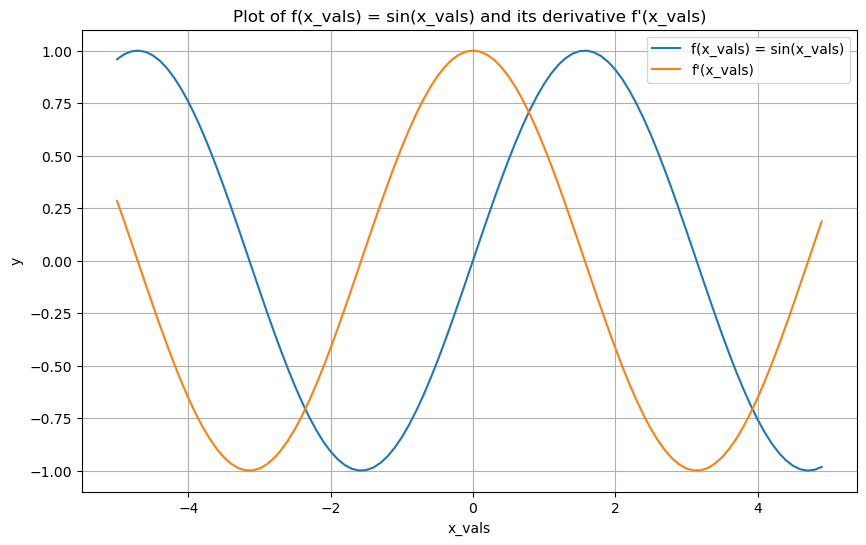

In [8]:
def sin(x_vals):
    return torch.sin(x_vals)


x_vals = torch.arange(-5, 5, 0.1)
x_vals.requires_grad = True
y = sin(x_vals)
y_prime = torch.autograd.grad(y.sum(), x_vals, create_graph=True)[0]

# Autograd takes the single value and the variable to differentatiate to respect with

# Plot f(x_vals) and its derivative f'(x_vals)
plt.figure(figsize=(10, 6))
plt.plot(x_vals.detach().numpy(), y.detach().numpy(), label='f(x_vals) = sin(x_vals)')
plt.plot(x_vals.detach().numpy(), y_prime.detach().numpy(), label="f'(x_vals)")
plt.xlabel('x_vals')
plt.ylabel('y')
plt.title('Plot of f(x_vals) = sin(x_vals) and its derivative f\'(x_vals)')
plt.legend()
plt.grid(True)
plt.show()

#### For a second order differentiation

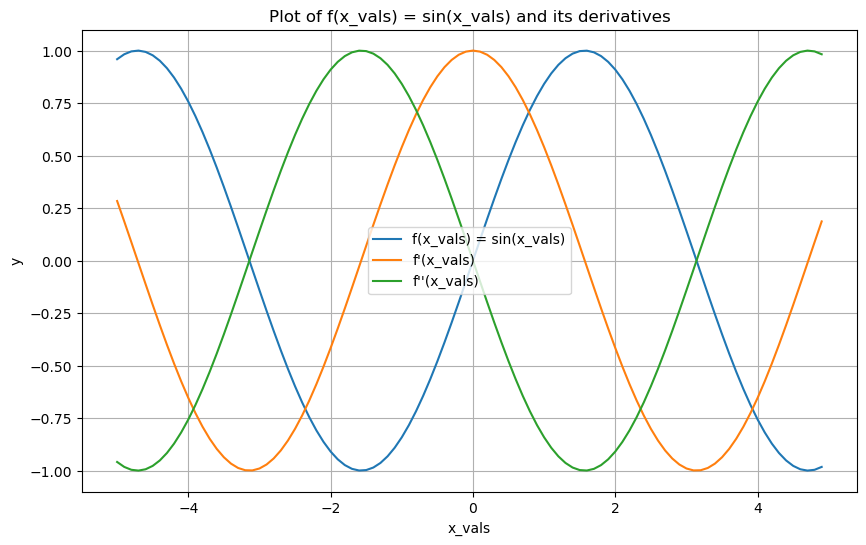

In [9]:
def sin(x_vals):
    return torch.sin(x_vals)

x_vals = torch.arange(-5, 5, 0.1)
x_vals.requires_grad = True
y = sin(x_vals)
y_prime = torch.autograd.grad(y.sum(), x_vals, create_graph=True)[0]
y_double_prime = torch.autograd.grad(y_prime.sum(), x_vals)[0]

# Plot f(x_vals), its first derivative f'(x_vals), and its second derivative f''(x_vals)
plt.figure(figsize=(10, 6))
plt.plot(x_vals.detach().numpy(), y.detach().numpy(), label='f(x_vals) = sin(x_vals)')
plt.plot(x_vals.detach().numpy(), y_prime.detach().numpy(), label="f'(x_vals)")
plt.plot(x_vals.detach().numpy(), y_double_prime.detach().numpy(), label="f''(x_vals)")
plt.xlabel('x_vals')
plt.ylabel('y')
plt.title('Plot of f(x_vals) = sin(x_vals) and its derivatives')
plt.legend()
plt.grid(True)
plt.show()

### Detaching Computation

Sometimes, we wish to **move some calculations
outside of the recorded computational graph.**
For example, say that we use the input 
to create some auxiliary intermediate terms 
for which we do not want to compute a gradient. 
In this case, we need to *detach* 
the respective computational graph
from the final result. 
The following toy example makes this clearer: 
suppose we have `z = x * y` and `y = x * x` 
but we want to focus on the *direct* influence of `x` on `z` 
rather than the influence conveyed via `y`. 
In this case, we can create a new variable `u`
that takes the same value as `y` 
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `x`,
(not `3 * x * x` as you might have 
expected since `z = x * x * x`).


In [10]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`, 
the computational graph leading to `y` 
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [11]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

#### Gradients and Python Control Flow

So far we reviewed cases where the path from input to output 
was well-defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results. 
For instance, we can make them depend on auxiliary variables 
or condition choices on intermediate results. 
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of 
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where 
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [12]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value as input.
Since the input is a random variable, 
we do not know what form 
the computational graph will take.
However, whenever we execute `f(a)` 
on a specific input, we realize 
a specific computational graph
and can subsequently run `backward`.


In [13]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

Even though our function `f` is a bit 
contrived for demonstration purposes,
its dependence on the input is quite simple: 
it is a *linear* function of `a` 
with piecewise defined scale. 
As such, `f(a) / a` is a vector of constant entries 
and, moreover, `f(a) / a` needs to match 
the gradient of `f(a)` with respect to `a`.


In [14]:
a.grad == d / a

tensor(True)